**CS230 Final Project**

This notebook carries out data processing and model training. Model training is implemented using PyTorch's [SemTorch](https://pypi.org/project/SemTorch/) and [FastAI](https://pypi.org/project/fastai/) libraries. Some of the training code is adapted from [Castillo (2020)'s](https://github.com/WaterKnight1998/Deep-Tumour-Spheroid) implementation of the SemTorch library for tumor segmentation.

In [ ]:
%%capture
!pip install fastai
!pip install semtorch
!pip install torchmetrics

In [ ]:
%%capture
!pip install awscli
!pip install s3fs

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

import torch
from torch import nn
from torchvision.models.resnet import resnet34
import torch.nn.functional as F
from torchvision import transforms

from pathlib import Path
import random

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# SemTorch
from semtorch import get_segmentation_learner

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
%matplotlib inline
import numpy as np
import zipfile
import shutil
from tqdm import tqdm
from PIL import Image
from google.colab import files

In [ ]:
# AWS configs
import awscli
import s3fs

In [ ]:
# Setting random seed for reproduceability
set_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Set up AWS configure
!aws configure

In [ ]:
ls

sample_data/


In [ ]:
!mkdir semantic-segmentation

In [ ]:
ls

sample_data/  semantic-segmentation/


In [ ]:
!mkdir ./semantic-segmentation/data-processing

In [ ]:
%%capture
# Extract masks
!aws s3 cp s3://blender-satellite-renders/no-palette-masks/no-palette-masks-near.zip ./semantic-segmentation/
!aws s3 cp s3://blender-satellite-renders/no-palette-masks/no-palette-masks-chandra.zip ./semantic-segmentation/
!aws s3 cp s3://blender-satellite-renders/no-palette-masks/no-palette-masks-ibex.zip ./semantic-segmentation/
!aws s3 cp s3://blender-satellite-renders/no-palette-masks/no-palette-masks-cluster-ii.zip ./semantic-segmentation/
!aws s3 cp s3://blender-satellite-renders/no-palette-masks/no-palette-masks-clementine.zip ./semantic-segmentation/

# Create directories for the masks
!mkdir ./semantic-segmentation/data-processing/NEAR
!mkdir ./semantic-segmentation/data-processing/chandra
!mkdir ./semantic-segmentation/data-processing/ibex
!mkdir ./semantic-segmentation/data-processing/clusterII
!mkdir ./semantic-segmentation/data-processing/clementine

# Unzip the masks
with zipfile.ZipFile('./semantic-segmentation/no-palette-masks-near.zip', 'r') as zip_ref:
    zip_ref.extractall('./semantic-segmentation/data-processing/NEAR')

with zipfile.ZipFile('./semantic-segmentation/no-palette-masks-chandra.zip', 'r') as zip_ref:
    zip_ref.extractall('./semantic-segmentation/data-processing/chandra')

with zipfile.ZipFile('./semantic-segmentation/no-palette-masks-ibex.zip', 'r') as zip_ref:
    zip_ref.extractall('./semantic-segmentation/data-processing/ibex')

with zipfile.ZipFile('./semantic-segmentation/no-palette-masks-cluster-ii.zip', 'r') as zip_ref:
    zip_ref.extractall('./semantic-segmentation/data-processing/clusterII')

with zipfile.ZipFile('./semantic-segmentation/no-palette-masks-clementine.zip', 'r') as zip_ref:
    zip_ref.extractall('./semantic-segmentation/data-processing/clementine')

In [ ]:
%%capture
# Extract base images
!aws s3 cp s3://blender-satellite-renders/stage-NEAR-v0.tar.gz ./semantic-segmentation/data-processing/stage-NEAR-v0.tar.gz
!aws s3 cp s3://blender-satellite-renders/stage-chandra-v0.tar.gz ./semantic-segmentation/data-processing/stage-chandra-v0.tar.gz
!aws s3 cp s3://blender-satellite-renders/stage-ibex-v0.tar.gz ./semantic-segmentation/data-processing/stage-ibex-v0.tar.gz
!aws s3 cp s3://blender-satellite-renders/stage-clusterII-v0.tar.gz ./semantic-segmentation/data-processing/stage-clusterII-v0.tar.gz
!aws s3 cp s3://blender-satellite-renders/stage-clementine-v0.tar.gz ./semantic-segmentation/data-processing/stage-clementine-v0.tar.gz

# Create directories for the base images
!mkdir ./semantic-segmentation/data-processing/NEAR_images
!mkdir ./semantic-segmentation/data-processing/chandra_images
!mkdir ./semantic-segmentation/data-processing/ibex_images
!mkdir ./semantic-segmentation/data-processing/clusterII_images
!mkdir ./semantic-segmentation/data-processing/clementine_images

# Untar base image
!tar -xvzf ./semantic-segmentation/data-processing/stage-NEAR-v0.tar.gz --directory ./semantic-segmentation/data-processing
!tar -xvzf ./semantic-segmentation/data-processing/stage-chandra-v0.tar.gz --directory ./semantic-segmentation/data-processing
!tar -xvzf ./semantic-segmentation/data-processing/stage-ibex-v0.tar.gz --directory ./semantic-segmentation/data-processing
!tar -xvzf ./semantic-segmentation/data-processing/stage-clusterII-v0.tar.gz --directory ./semantic-segmentation/data-processing
!tar -xvzf ./semantic-segmentation/data-processing/stage-clementine-v0.tar.gz --directory ./semantic-segmentation/data-processing

# Move images into the correct folders
!mv ./semantic-segmentation/data-processing/stage-NEAR-v0/image_*  ./semantic-segmentation/data-processing/NEAR_images
!mv ./semantic-segmentation/data-processing/stage-chandra-v0/image_*  ./semantic-segmentation/data-processing/chandra_images
!mv ./semantic-segmentation/data-processing/stage-ibex-v0/image_*  ./semantic-segmentation/data-processing/ibex_images
!mv ./semantic-segmentation/data-processing/stage-clusterII-v0/image_*  ./semantic-segmentation/data-processing/clusterII_images
!mv ./semantic-segmentation/data-processing/stage-clementine-v0/image_*  ./semantic-segmentation/data-processing/clementine_images

In [ ]:
# Now, append the satellite name at the front of all base images
for root, dirs, files in os.walk("semantic-segmentation/data-processing/NEAR_images"):
    if not files:
        continue
    prefix = "NEAR"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/chandra_images"):
    if not files:
        continue
    prefix = "chandra"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/ibex_images"):
    if not files:
        continue
    prefix = "ibex"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/clusterII_images"):
    if not files:
        continue
    prefix = "clusterII"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/clementine_images"):
    if not files:
        continue
    prefix = "clementine"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

In [ ]:
# Now, append the satellite name at the front of all labeled images
for root, dirs, files in os.walk("semantic-segmentation/data-processing/NEAR"):
    if not files:
        continue
    prefix = "NEAR"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1].split('_', 1)[1].split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/chandra"):
    if not files:
        continue
    prefix = "chandra"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1].split('_', 1)[1].split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/ibex"):
    if not files:
        continue
    prefix = "ibex"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1].split('_', 1)[1].split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/clusterII"):
    if not files:
        continue
    prefix = "clusterII"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1].split('_', 1)[1].split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/data-processing/clementine"):
    if not files:
        continue
    prefix = "clementine"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1].split('_', 1)[1].split('_', 1)[1])))


In [ ]:
# Create a FINAL image and mask folder
os.mkdir('semantic-segmentation/Images')
os.mkdir('semantic-segmentation/Masks')

In [ ]:
# Create three different datasets in each folder
os.mkdir('semantic-segmentation/Images/Train_Valid') # Data for training and validation
os.mkdir('semantic-segmentation/Images/Test') # Data for testing with the 4 main satellites (in-distribution)
os.mkdir('semantic-segmentation/Images/Test-Unseen-Satellite') # Testing with Clementine, the completely unseen satellite (out-of-distribution)

os.mkdir('semantic-segmentation/Masks/Train_Valid') # Data for training and validation
os.mkdir('semantic-segmentation/Masks/Test') # Data for testing with the 4 main satellites (in-distribution)
os.mkdir('semantic-segmentation/Masks/Test-Unseen-Satellite') # Testing with Clementine, the completely unseen satellite (out-of-distribution)

In [ ]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file

In [ ]:
# Split into two buckets - one is a hold-out in-distribution test set and one is for training + validation
# Split the main 4 satellites into these two buckets
for satellite in ['NEAR', 'chandra', 'clusterII', 'ibex']:

  image_dir = 'semantic-segmentation/data-processing/' + satellite + '_images/'
  masks_dir = 'semantic-segmentation/data-processing/' + satellite
  images = [x for x in os.listdir(image_dir) if x[-3:] == 'png']
  maps = [x for x in os.listdir(masks_dir) if x[-3:] == 'png']

  for image in tqdm(images):
      target_set_img = 'semantic-segmentation/Images/Train_Valid' if random.randint(0, 99) < 90 else 'semantic-segmentation/Images/Test' # 90-10 split

      target_set_mask = 'semantic-segmentation/Masks/Train_Valid' if target_set_img == 'semantic-segmentation/Images/Train_Valid' else 'semantic-segmentation/Masks/Test'
      
      image_file_path = os.path.join(image_dir, image)
      image_target_path = os.path.join(target_set_img, image)
      
      map_file_path = os.path.join(masks_dir, get_map_file(image)) # Get the corresponding file from the Masks folder
      map_target_path = os.path.join(target_set_mask, get_map_file(image))
      
      shutil.copy(image_file_path, image_target_path)
      shutil.copy(map_file_path, map_target_path)

100%|██████████| 15000/15000 [00:10<00:00, 1461.67it/s]


In [ ]:
# Now shift ONLY the out-of-distribution satellite (Clementine) into the unseen folder. This is for out-of-distribution testing
image_dir = 'semantic-segmentation/data-processing/' + 'clementine' + '_images/'
masks_dir = 'semantic-segmentation/data-processing/' + 'clementine'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'png']
maps = [x for x in os.listdir(masks_dir) if x[-3:] == 'png']

for image in tqdm(images):
    target_set_img = 'semantic-segmentation/Images/Test-Unseen-Satellite'

    target_set_mask = 'semantic-segmentation/Masks/Test-Unseen-Satellite'
    
    image_file_path = os.path.join(image_dir, image)
    image_target_path = os.path.join(target_set_img, image)
    
    map_file_path = os.path.join(masks_dir, get_map_file(image)) # Get the corresponding file from the Masks folder
    map_target_path = os.path.join(target_set_mask, get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 1500/1500 [00:00<00:00, 2745.92it/s]


In [ ]:
# Set up Images and Labels paths
path = Path("./semantic-segmentation/")
path_images = path/"Images"
path_labels = path/"Masks"

test_name = "Test"

In [ ]:
fnames = get_image_files(path_images)
lbl_names = get_image_files(path_labels)

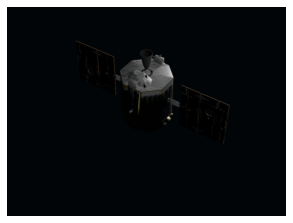

In [ ]:
img_fn = fnames[1102]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [ ]:
# Grabs the mask for a given base image
get_y_fn = lambda x: Path(str(x).replace("Images","Masks"))

In [ ]:
msk = PILMask.create(get_y_fn(img_fn))

In [ ]:
type(msk)

fastai.vision.core.PILMask

In [ ]:
# Vocabulary of Class Labels
codes = np.array(["Background", "Solar Panels", "Drive Shaft", "Parabolic Antenna", "Satellite Dish", "Main Module",
                 "Telescope", "Main Thrusters", "Rotational Thrusters", "Sensors", "Launch Vehicle Adapter"])

def classes_present(tensr):
  present_classes = []
  for i in range(11):
    if i in tensr:
      present_classes.append(codes[i])
  return present_classes

name2id = {v:k for k,v in enumerate(codes)}

In [ ]:
classes_present(tensor(msk))

['Background',
 'Solar Panels',
 'Drive Shaft',
 'Parabolic Antenna',
 'Satellite Dish',
 'Main Module',
 'Main Thrusters',
 'Rotational Thrusters',
 'Sensors']

In [ ]:
torch.unique(tensor(msk))

tensor([0, 1, 2, 3, 4, 5, 7, 8, 9], dtype=torch.uint8)

In [ ]:
# Early Stopping
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [ ]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [ ]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img, mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [ ]:
manual_name="Train_Valid"

path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

semantic-segmentation/Images/Train_Valid/NEAR_312_3.png


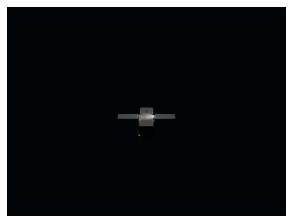

In [ ]:
# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [ ]:
# Resize image size
size = 256

In [ ]:
# Dice + Focal Loss Function
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

**Architecture 1: UNet**

In [ ]:
# Define DataBlock and DataLoader
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=8)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))
dls.vocab=codes

In [ ]:
# 48694 images loaded in (this should be training data which is 0.9 * 0.9 * 60k)
len(dls.dataset)

48694

In [ ]:
# Variant 1 - CCE Loss
learn = get_segmentation_learner(dls=dls, number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[DiceMulti()],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="unet-cce"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(1e-5,1e-4), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
# Variant 2 - Dice Loss
learn = get_segmentation_learner(dls=dls, loss_func=DiceLoss(), number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[DiceMulti()],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="unet-dice"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(1e-5,1e-4), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
# Variant 3 - Dice + Focal Loss
learn = get_segmentation_learner(dls=dls, loss_func=CombinedLoss(), number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[DiceMulti()],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="unet-dice+focal"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(1e-5,1e-4), cbs=callbacksFitBeforeUnfreeze)

**Architecture 2 - HRNet**

In [ ]:
# Define DataBlock and DataLoader
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=16)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))
dls.vocab=codes

def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

In [ ]:
# Variant 1 - CCE Loss
learn = get_segmentation_learner(dls=dls,
                                 number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[DiceMulti()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="hr-cce"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(5e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
# Variant 2 - Dice Loss
learn = get_segmentation_learner(dls=dls, loss_func=DiceLoss(),
                                 number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[DiceMulti()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="hr-dice"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(5e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
# Variant 3 - Dice + Focal Loss
learn = get_segmentation_learner(dls=dls, loss_func=CombinedLoss(),
                                 number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[DiceMulti()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="hr-dice+focal"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(5e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)

**Architecture 3 - DeepLabv3+**

In [ ]:
# Define DataBlock and DataLoader
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=16)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))
dls.vocab=codes

def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)] #Freeze backbone, tune head

In [ ]:
# Variant 1 - CCE Loss
learn = get_segmentation_learner(dls=dls, number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[DiceMulti()],wd=1e-2, #Weight Decay
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="deeplab-cce"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(5e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
# Variant 2 - Dice Loss
learn = get_segmentation_learner(dls=dls, loss_func=DiceLoss(), number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[DiceMulti()],wd=1e-2, #Weight Decay
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="deeplab-dice"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(5e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
# Variant 3 - Dice + Focal Loss
learn = get_segmentation_learner(dls=dls, loss_func=CombinedLoss(), number_classes=11, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[DiceMulti()],wd=1e-2, #Weight Decay
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [ ]:
fname="deeplab-dice+focal"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(5e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)